# Titanic Predictions

This tutorial is based on an ongoing contest on Kaggle.com, a data science site that holds frequent contests. It is based off Menhav Seghal's [Titanic Data Science solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions) kernel.

The competition describes the question for us:

## Competition Description
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

The competition has divided the data into 2 files, `train` and `test`. Each set consist of a list of passengers. In the training set, we know if the person survived. In the test set, we have all of the same information except status. Our goal is to try to accurately predict the survival status for the test passengers. This tutorial compares several different machine learning approaches to see which works best.

First we'll load all the tools we'll need

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

Python Pandas uses a structure called a dataframe. It's like a table, but it can do a lot of math operations that make it particularly helpful for machine learning. To get our data out of the csv file and into dataframes, we use:

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Kaggle provides a description of the data [here](https://www.kaggle.com/c/titanic/data)

To view the header (first few lines) of the dataframe, we use the head method by adding .head() to the end of the dataframe's name

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


What is the data type for each column (nominal, ordered, interval and ratio)? What operations are meaningful for this type?

NaN is "Not a Number" - it's a common marker for missing data. We see that even in these few lines, many cabin numbers are missing.

We can use the describe method to see everything that's missing, as well as the range of numeric values:

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can also describe non-numeric values, seeing how many unique values there are and what is most frequent. 

In [5]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Moubarek, Master. Gerios",male,347082,G6,S
freq,1,577,7,4,644


Repeat this to see what the test_df looks like.

Data insights:
    
1. Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and ticket number is unlikely to have a correlation with survival.
2. Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin. Cabin feature may be dropped as it is highly incomplete or contains many null values.
3. PassengerId may be dropped from training dataset as it does not contribute to survival.
4. We are missing many ages, 2 'Embarked' values, and 1 fare (from the test data)   

Let's see if passenger class correlates with survival. The groupby method allows us to organize dataframe or part of one. Here we take the passenger class and survived columns, group by class, and find the mean value for each class.

In [6]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


So 1st class passengers had 63% survival, and 3rd class has 24%. Which other values seem to correlate with survival? Copy and modify code above to look at a few other columns.

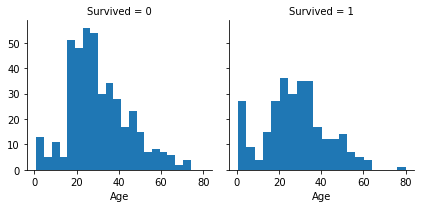

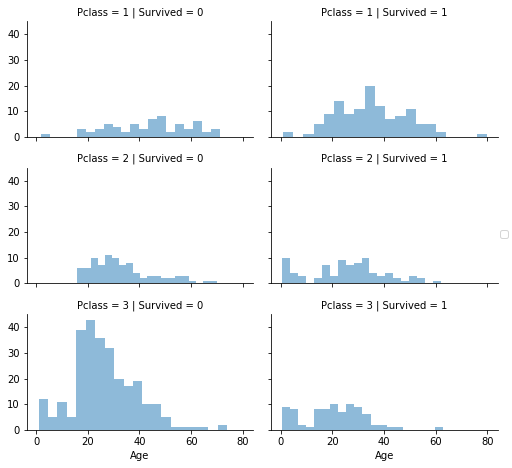

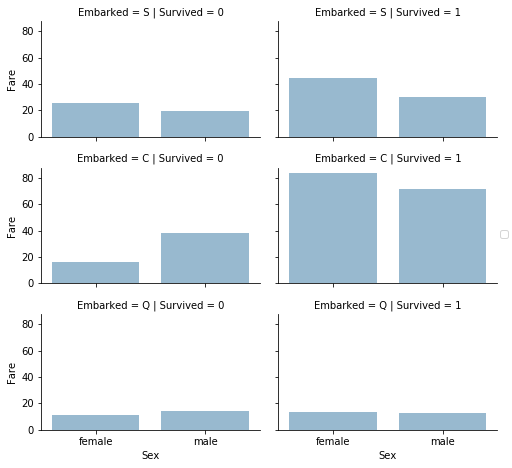

In [7]:
chartAge = sns.FacetGrid(train_df, col='Survived')
chartAge.map(plt.hist, 'Age', bins=20)

chartClass = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
chartClass.map(plt.hist, 'Age', alpha=.5, bins=20)
chartClass.add_legend();

chartFare = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
chartFare.map(sns.barplot, 'Sex', 'Fare', alpha=.5, order = ["female", "male"],ci=None)
chartFare.add_legend()

1. Women were more likely to have survived.
2. Children (Age<?) were more likely to have survived. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.

'Fare' 'Sibsp' and 'Parch'are generally related, but there are a lot of choices that don't tell us much. 
3. Let's create a Fare range feature instead of using actual fares.
4. Let's create a new feature based on Parch and SibSp to get total count of family members on board.

# Cleaning the data

#### Dropping data
First let's drop the columns we don't want. I've done 'Ticket' 'Cabin'. You should drop 'PassengerId' and 'Name' from training, but only 'Name' from test (the contest goal is to return a prediction for each id, so we need to keep those 

In [8]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)

In [11]:
#Show part of df to see if the correct columns dropped
train_df.tail()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
886,0,2,male,27.0,0,0,13.00,S
887,1,1,female,19.0,0,0,30.00,S
888,0,3,female,NaN,1,2,23.45,S
889,1,1,male,26.0,0,0,30.00,C
890,0,3,male,32.0,0,0,7.75,Q


#### Filling in  missing values



We'll need to fill in values and do other cleaning on both of our dataframes, so we'll create a combined list

In [12]:
combine = [train_df, test_df]

To complete the Embarked field, we'll use the most common port

In [13]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [14]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

Here we fill in the missing fare using the average value. I've chosen to do this on a single line rather than making a variable for the average fare, just to show that you can

In [15]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

Let's look at our info to make sure that worked

In [16]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


We see that the number of non-null objects is consistent, except for Age.
Age is obviously important for this task, and to fill in the missing age values we're going to do estimate. But instead of just using an average over everyone, we're going to use class and gender to help make better estimates, so we'll hold off on this for now.

#### Converting  categorical features into nominal values
Now we can convert features which contain strings to numerical values. This is required by most model algorithms. We want to do this for both test and train, so we'll create a list called combine. It can be confusing to share data that has numbers for values (does 1 mean male or female?) so it's better practice to do this step just before you need the numbers, not in data you're going to share.

Let's convert the Embarked ports letters into numbers

In [17]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,2
1,893,3,female,47.0,1,0,7.0000,0
2,894,2,male,62.0,0,0,9.6875,2
3,895,3,male,27.0,0,0,8.6625,0
4,896,3,female,22.0,1,1,12.2875,0


In [18]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

    #Look at a portion of the dataframe to see if it worked
train_df.tail()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
886,0,2,0,27.0,0,0,13.00,0
887,1,1,1,19.0,0,0,30.00,0
888,0,3,1,NaN,1,2,23.45,0
889,1,1,0,26.0,0,0,30.00,1
890,0,3,0,32.0,0,0,7.75,2


Now we can fill in the missing ages. We'll divide the data into 6 buckets based on passenger ticket class and gender (1st class female, 2nd class female, 3rd class female, 1st class male, 2nd class male, 3rd class male) and find the average age for each bucket. THen we'll replace all the NaN's with the correct average.

In [19]:
#we create an array to store our age guesses
guess_ages = np.zeros((2,3))

#then we find the average for each bucket
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.tail()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
886,0,2,0,27,0,0,13.00,0
887,1,1,1,19,0,0,30.00,0
888,0,3,1,21,1,2,23.45,0
889,1,1,0,26,0,0,30.00,1
890,0,3,0,32,0,0,7.75,2


#### Converting numerical data into categorical
Let's divide the Ages into bands. Let's see where the ages break if we use 5 bins

In [20]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [21]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
    
#Now we're done with AgeBand so we drop it, and reset combine
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,1,1,0,7.2500,0
1,1,1,1,2,1,0,71.2833,1
2,1,3,1,1,0,0,7.9250,0
3,1,1,1,2,1,0,53.1000,0
4,0,3,0,2,0,0,8.0500,0


Let's do the same thing for Fares

In [22]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [23]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,1,1,0,0,0
1,1,1,1,2,1,0,3,1
2,1,3,1,1,0,0,1,0
3,1,1,1,2,1,0,3,0
4,0,3,0,2,0,0,1,0
5,0,3,0,1,0,0,1,2
6,0,1,0,3,0,0,3,0
7,0,3,0,0,3,1,2,0
8,1,3,1,1,0,2,1,0
9,1,2,1,0,1,0,2,1


#### Create new feature combining existing features¶
We can create a new feature which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.

In [24]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [25]:
train_df = train_df.drop(['Parch', 'SibSp'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,0,1,0,0,2
1,1,1,1,2,3,1,2
2,1,3,1,1,1,0,1
3,1,1,1,2,3,0,2
4,0,3,0,2,1,0,1


## Model, predict and solve
Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

Logistic Regression
KNN or k-Nearest Neighbors
Support Vector Machines
Naive Bayes classifier
Decision Tree
Random Forrest
Perceptron
Artificial neural network
RVM or Relevance Vector Machine

First we need to get our data into x,y format, where x are the features we provide and y are the predictions. Check to make sure we have the correct fields for each file.

In [27]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 6), (891,), (418, 6))

Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. [Reference] (http://faculty.cas.usf.edu/mbrannick/regression/Logistic.html).

This prints the confidence score generated by the model based on our training dataset.

In [28]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.25

Next we'll try the k-Nearest Neighbors algorithm (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. [Reference](https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/).

KNN confidence score is better than Logistics Regression in our case.

In [29]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

85.299999999999997

Naive Bayes is a form of ML that requires that works if your features are independent. This probably won't work well for us. There should be a relationship between ticket class and fare, for example. [Reference](https://medium.com/machine-learning-101/chapter-1-supervised-learning-and-naive-bayes-classification-part-1-theory-8b9e361897d5)

And yes, just like we thought, this gives a worse score.

In [30]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

76.879999999999995

Here's the decision tree again, as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. [Reference](https://en.wikipedia.org/wiki/Decision_tree) 

In [31]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

87.430000000000007

In [34]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=200)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

87.430000000000007

In [36]:
# Stochastic Gradient Descent

sgd = SGDClassifier(max_iter=5,tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

78.0

In [37]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

79.799999999999997

Run your preferred algorithm one more time, and then the following code if you want to make a contest submission.

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)